This problem was asked by Google.

You are given an M by N matrix consisting of booleans that represents a board. Each True boolean represents a wall. Each False boolean represents a tile you can walk on.

Given this matrix, a start coordinate, and an end coordinate, return the minimum number of steps required to reach the end coordinate from the start. If there is no possible path, then return null. You can move up, left, down, and right. You cannot move through walls. You cannot wrap around the edges of the board.

For example, given the following board:
```
[[f, f, f, f],
[t, t, f, t],
[f, f, f, f],
[f, f, f, f]]
```
and start = `(3, 0)` (bottom left) and end = `(0, 0)` (top left), the minimum number of steps required to reach the end is 7, since we would need to go through `(1, 2)` because there is a wall everywhere else on the second row.

In [251]:
class DistMemo(dict):
    def __missing__(self, key):
        return float("inf")

def min_dist_2d(board, start, end, verbose=False):
    """
    Find shortest distance between start and end tiles on board.
    
    Uses a generic graph traversal algorithm with memoisation
    and pruning. Cycles are avoided by storing visited tiles.
    
    @param board: 2d-array of booleans (M lists each of length N). 
        Elements set to True are walls and cannot be crossed.
    @param start, end: two tuples containing start and end coordinates.
        First and second element of tuple are indices for 
        M and N coordinate respectively.
    
    Returns integer number of steps, or float("inf") if no path exists.
    """
    min_dist_memo = DistMemo()
    visited = set()
    return min_dist_2d_exec(board, start, end, visited, min_dist_memo, verbose)

def min_dist_2d_exec(board, start, end, visited, min_dist_memo, verbose):
    
    visited.add(start)
    
    if start == end:
        return 0
    
    for tile in get_neighbouring_unvisited_tiles(board, start, visited):
        
        if verbose: print_info(start, end, tile, visited, min_dist_memo)
        
        # pruning: skip neighbour if it can be ruled out as a detour based on its L1-norm
        if 1 + L1_norm(tile, end) < min_dist_memo[(start, end)]:
            
            # memo: compute min_dist_memo[(tile, end)] if it is not memoised
            if (tile, end) not in min_dist_memo:
                min_dist_memo[(tile, end)] = min_dist_2d_exec(board, tile, end, visited, min_dist_memo, verbose)
            
            # update min_dist_memo[(start, end)] if a shorter path is found
            if 1 + min_dist_memo[(tile, end)] < min_dist_memo[(start, end)]:
                min_dist_memo[(start, end)] = 1 + min_dist_memo[(tile, end)]
    
    if verbose: print("Callback")
    return min_dist_memo[(start, end)]

def L1_norm(x, y):
    dist = 0
    for xi, yi in zip(x, y):
        dist += abs(xi-yi)
    return dist

def dim_2d(board):
    M = len(board)
    N = len(board[0])
    return (M, N)

def get_neighbouring_unvisited_tiles(board, coord, visited):
    """
    Return a tuple containing the neighbouring tiles to coord
    that have not yet been visited (i.e. that are not contained in visited).
    
    @param board: 2d-array of booleans (M lists each of length N). 
        Elements set to True are walls and cannot be crossed.
    @param coord: tuple containing coordinates.
        First and second element of tuple are indices for 
        M and N coordinate respectively.
    @param visited: set containing tuples of visited coordinates.
    """
    M, N = dim_2d(board)
    m_coord, n_coord = coord
    tiles = set()
    for m_step, n_step in ((0,1), (1,0), (0,-1), (-1,0)):
        m_next = m_coord + m_step
        n_next = n_coord + n_step
        move_is_on_unvisited_tile = (
            m_next >= 0 and m_next < M
            and n_next >= 0 and n_next < N
            and (m_next, n_next) not in visited
            and board[m_next][n_next] is False
        )
        if move_is_on_unvisited_tile:
            tiles.add( (m_next, n_next) )    
    return tiles

def print_info(start, end, tile, visited, min_dist_memo):
    m_start, n_start = start
    m_pos, n_pos = tile
    print(
        "From", start, "To", tile,
        "; is_detour=", 1 + L1_norm(tile, end) >= min_dist_memo[(start, end)],
        "; min_dist=", min_dist_memo
    )

In [252]:
board = [[False, False, False, False],
[True, True, False, True],
[False, False, False, False],
[False, False, False, False]]

assert min_dist_2d(board, (3,0), (0,0)) == 7

In [253]:
board = [[False, False, False, False],
[True, True, False, True],
[False, False, False, False],
[False, False, False, False]]

assert min_dist_2d(board, (0,0), (3,0)) == 7

In [254]:
board = [[False, False, False, False],
[True, True, True, True],
[False, False, False, False],
[False, False, False, False]]

assert min_dist_2d(board, (3,0), (0,0)) == float("inf")

In [286]:
import itertools
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import math

def runtime(fun, *args):
    """ Return the execution time of fun with arguments *args """
    start = timer()
#     print(fun(arr))
    res = fun(*args)
    end = timer()
    return end-start

def benchmark(fun, min_arr_size=1, max_arr_size=79, n=10):
    """ 
    Benchmark runtime of function fun with 2d-arrays of varying size. 
    Return a DataFrame specifying execution times in seconds for a
    set of list lengths.
    """
    bench_df = pd.DataFrame({
        'arr_len': np.logspace(
            math.log10(min_arr_size),
            math.log10(max_arr_size),
            num=n,
            dtype=np.int32
        ),
        'execution_time': np.empty(n)
    })
    bench_df['arr_size'] = bench_df['arr_len'] ** 2
    for i, n in enumerate(bench_df['arr_len']):
        board = [[False]*n for _ in range(n)]
        bench_df.at[i, 'execution_time'] = runtime(fun, board, (0,0), (n-1,n-1))
    return bench_df

In [287]:
stats_df = benchmark(min_dist_2d)
stats_df

,arr_len,execution_time,arr_size
0,1,0.000011,1
1,1,0.000008,1
2,2,0.000081,4
3,4,0.000178,16
4,6,0.000688,36
5,11,0.002379,121
6,18,0.009254,324
7,29,0.026999,841
8,48,0.054631,2304
9,78,0.123073,6084


Text(0.5, 1.0, 'dp memoised')

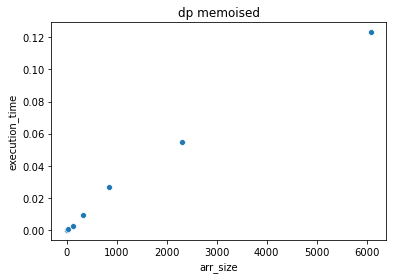

In [288]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.scatterplot('arr_size', 'execution_time', data=stats_df, ax=ax)
ax.set_title('dp memoised')